# CNN practice
For these exercises we'll work with the <a href='https://www.kaggle.com/zalando-research/fashionmnist'>Fashion-MNIST</a> dataset, also available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. Like MNIST, this dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot


## Perform standard imports, load the Fashion-MNIST dataset

PyTorch makes the Fashion-MNIST dataset available through <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist'><tt><strong>torchvision</strong></tt></a>. The first time it's called, the dataset will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../Data', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

In [2]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 1. Create data loaders
Use DataLoader to create a <tt>train_loader</tt> and a <tt>test_loader</tt>. Batch sizes should be 10 for both.

In [14]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## 2. Examine a batch of images
Use DataLoader, <tt>make_grid</tt> and matplotlib to display the first batch of 10 images.<br>
display the labels as well

Label:  [3 4 9 2 4 7 3 5 3 2]
Class:  Dress Coat Boot Sweater Coat Sneaker Dress Sandal Dress Sweater


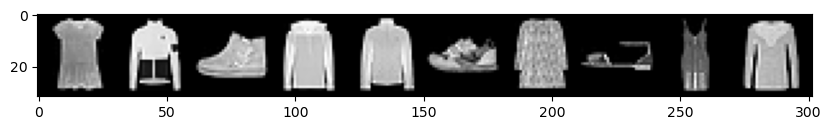

In [5]:
for images, labels in train_loader:
    break

# Print the images
im = make_grid(images, nrow=10)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

print('Label: ', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

## Downsampling
<h3>3. If a 28x28 image is passed through a Convolutional layer using a 5x5 filter, a step size of 1, and no padding, what is the resulting matrix size?</h3>

In [6]:
conv = nn.Conv2d(1, 1, 5, 1)
for x,labels in train_loader:
    print('Orig size:',x.shape)
    break
x = conv(x)
print('Down size:',x.shape)

Orig size: torch.Size([10, 1, 28, 28])
Down size: torch.Size([10, 1, 24, 24])


### 4. If the sample from question 3 is then passed through a 2x2 MaxPooling layer, what is the resulting matrix size?

In [7]:
x = F.max_pool2d(x, 2, 2)
print('Down size:',x.shape)

Down size: torch.Size([10, 1, 12, 12])


## CNN definition
### 5. Define a convolutional neural network
Define a CNN model that can be trained on the Fashion-MNIST dataset. The model should contain two convolutional layers, two pooling layers, and two fully connected layers. You can use any number of neurons per layer so long as the model takes in a 28x28 image and returns an output of 10. Portions of the definition have been filled in for convenience.

In [15]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(4*4*16, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 4*4*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
torch.manual_seed(101)
model = ConvolutionalNetwork()

## Trainable parameters

In [9]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [10]:
count_parameters(model)

   150
     6
  2400
    16
 30720
   120
  7200
    60
   600
    10
______
 41282


### 7. Define loss function & optimizer
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used Cross Entropy Loss and Adam (learning rate of 0.001) respectively.

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 8. Train the model
Tracking loss values, displaying results, or validating the test set. Train the model through 5 epochs and evaluate the trained model. <br>
Print something after each epoch to indicate training progress.

In [17]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        # Backpropagation to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%1000 == 0:
            print(f'epoch: {i:2} batch: {b:4} [{10*b:6}/60000] loss: {loss.item():10.8f}  accuracy: {train_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(train_corr)

    # Run the test batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

total_time = time.time() - start_time
print(f'\n Duration: {total_time/60} minutes')

epoch:  0 batch: 1000 [ 10000/60000] loss: 0.47073594  accuracy:  66.680%
epoch:  0 batch: 2000 [ 20000/60000] loss: 0.58427137  accuracy:  72.225%
epoch:  0 batch: 3000 [ 30000/60000] loss: 0.46288595  accuracy:  74.817%
epoch:  0 batch: 4000 [ 40000/60000] loss: 0.26769882  accuracy:  76.815%
epoch:  0 batch: 5000 [ 50000/60000] loss: 0.47446561  accuracy:  78.212%
epoch:  0 batch: 6000 [ 60000/60000] loss: 0.89001048  accuracy:  79.285%
epoch:  1 batch: 1000 [ 10000/60000] loss: 0.47198153  accuracy:  85.890%
epoch:  1 batch: 2000 [ 20000/60000] loss: 0.63412696  accuracy:  85.705%
epoch:  1 batch: 3000 [ 30000/60000] loss: 0.28263843  accuracy:  85.943%
epoch:  1 batch: 4000 [ 40000/60000] loss: 0.47002596  accuracy:  86.025%
epoch:  1 batch: 5000 [ 50000/60000] loss: 0.47837964  accuracy:  86.204%
epoch:  1 batch: 6000 [ 60000/60000] loss: 0.00610273  accuracy:  86.375%
epoch:  2 batch: 1000 [ 10000/60000] loss: 0.27298850  accuracy:  87.650%
epoch:  2 batch: 2000 [ 20000/60000] l

## Save the model

In [19]:
torch.save(model.state_dict(), 'fashion_cnn_model_sm.pt')

## Plot the loss and accuracy comparisons

In [20]:
train_losses = list(loss.item() for loss in train_losses)

In [21]:
test_losses = list(loss.item() for loss in test_losses)

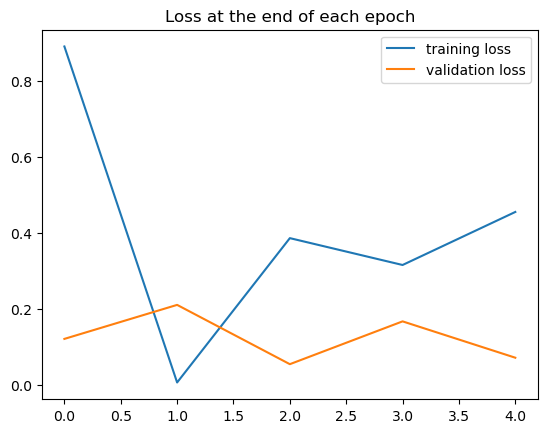

In [22]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

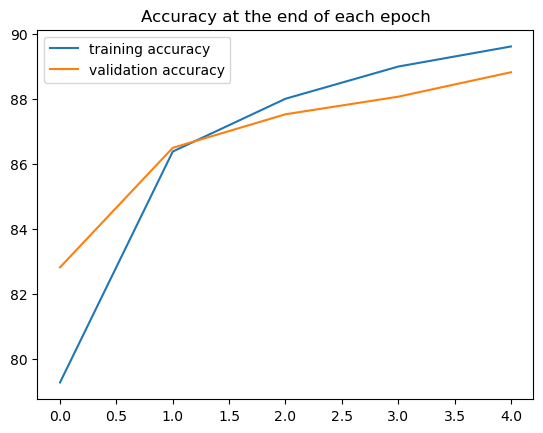

In [23]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

1 of 5 epochs completed
2 of 5 epochs completed
3 of 5 epochs completed
4 of 5 epochs completed
5 of 5 epochs completed


### 9. Evaluate the model
Set <tt>model.eval()</tt> and determine the percentage correct out of 10,000 total test images.

In [26]:
print(test_correct)
print('\n')
print(f'Test accuracy: {test_correct[-1].item()}/10000 = {test_correct[-1].item()*100/10000:.3f}%')

[tensor(8282), tensor(8649), tensor(8752), tensor(8806), tensor(8881)]


Test accuracy: 8881/10000 = 88.810%


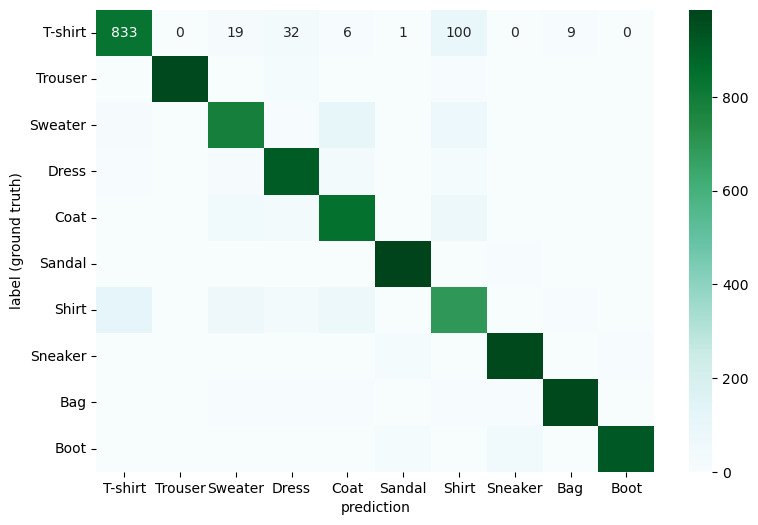

In [29]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();